We depend on this sync_lib library that is one folder above

In [1]:
import sys
sys.path.append('../')

In [2]:
from sync_lib import Dataset
import matplotlib.pylab as plt
import numpy as np

Path to relevant sync file

In [3]:
path = "2021T151449.h5"


In [4]:
dset = Dataset(path)

/Users/jeromel/anaconda2/envs/deep_work/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Here we plot the period of stimulus rendering, driving photo-diode and photo-diode response time after screen flipping

(0.9999499999999841, 1.0000200000000063)

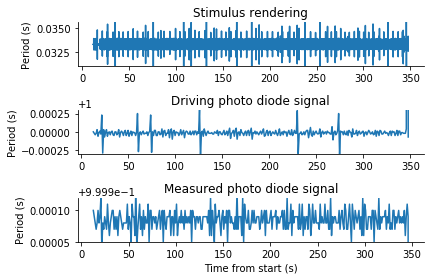

In [12]:

# This is the fastest output from bonsai to digital line
times_bonsai_fast_sync = dset.get_rising_edges('vsync_stim', units='sec')[10:-10]

# This is the driving signal behind the photodiode
times_bonsai_driving_photodiode = dset.get_rising_edges(
    'stim_running', units='sec')

times_photodiode = dset.get_rising_edges('stim_photodiode', units='sec')

plt.subplot(3, 1, 1)
y_axis_data = np.diff(times_bonsai_fast_sync)
plt.plot(times_bonsai_fast_sync[1:], y_axis_data)
plt.ylabel('Period (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Stimulus rendering')
plt.ylim([np.percentile(y_axis_data,0.1),np.percentile(y_axis_data,99.9)])

plt.subplot(3, 1, 2)
y_axis_data = np.diff(
    times_bonsai_driving_photodiode)
plt.plot(times_bonsai_driving_photodiode[1:], y_axis_data)
plt.ylabel('Period (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Driving photo diode signal')
plt.ylim([np.percentile(y_axis_data,0.5),np.percentile(y_axis_data,99.5)])

plt.subplot(3, 1, 3)
y_axis_data = np.diff(
    times_photodiode)
plt.plot(times_photodiode[1:], y_axis_data)
plt.xlabel('Time from start (s)')
plt.ylabel('Period (s)')
plt.title('Measured photo diode signal')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('go_no_go_hardware_2021T12950_sync_lines.png')
plt.ylim([np.percentile(y_axis_data,1),np.percentile(y_axis_data,99)])


This is to dive further into photodiode signal and visualize the stability of the photodiode period after flipping

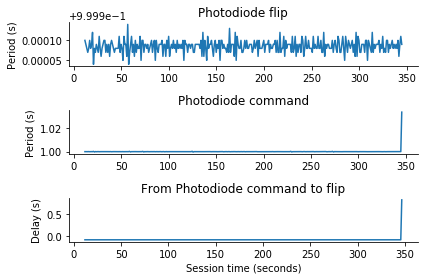

In [13]:

times_command = dset.get_rising_edges('stim_running', units='sec')
times_response = dset.get_rising_edges('stim_photodiode', units='sec')

plt.subplot(3, 1, 1)
plt.plot(times_response[:-2], np.diff(times_response[:-1]))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Period (s)')
plt.title('Photodiode flip')

plt.subplot(3, 1, 2)
plt.plot(times_command[:-2], np.diff(times_command[:-1]))
plt.ylabel('Period (s)')
plt.title('Photodiode command')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplot(3, 1, 3)
plt.plot(times_command[:-1], times_command[:-1]-times_response[0:times_command.shape[0]])

plt.ylabel('Delay (s)')
plt.xlabel('Session time (seconds)')
plt.title('From Photodiode command to flip')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()

Here we plot the *turn-around time* or the time it takes to immediately turn around a lick, ie. read a lick from sync on the arduino and convert to a digital line through DAQmx+NI card via Bonsai


Text(0, 0.5, 'Number of licks')

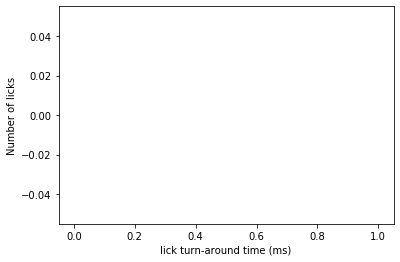

In [14]:
bit_trace = dset.get_bit_rising_edges(15, units='sec')
times_sync_licks = dset.get_rising_edges('lick_sensor', units='sec')[1:]
plt.hist(1000*(bit_trace-times_sync_licks))
plt.xlabel('lick turn-around time (ms)')
plt.ylabel('Number of licks')

Here we plot the time it takes to convert a lick into a reward. 
* *Calculation + digital line delay* is the time from Sync knowing a lick occured to the time sync received a reward from Bonsai. This time contains both the calculation reaction time as well as the time for Bonsai to read and write digital lines. 
* *Corrected calculation delay* is the same duration minus the local delay for Bonsai to turn around a pure lick. This represents the expected time it took bonsai to convert a lick into a reward. 

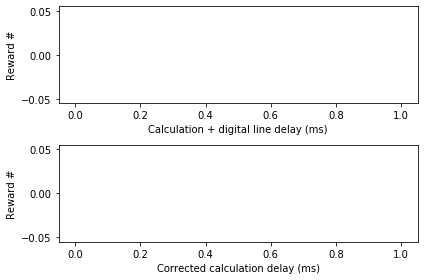

In [15]:
change_flash_times = dset.get_bit_rising_edges(6, units='sec')
reward_times = dset.get_bit_rising_edges(3, units='sec')
lick_in_out = dset.get_bit_rising_edges(15, units='sec')
lick_in = dset.get_rising_edges('lick_sensor', units='sec')[1:]

plt.subplot(2,1,1)
list_delta_reward = []
list_reward_x = []
for indiv_time in reward_times:
    all_delta_times = indiv_time-lick_in
    all_delta_times = all_delta_times[all_delta_times>0]
    local_time = np.min(all_delta_times)*1000
    list_reward_x.append(indiv_time)
    list_delta_reward.append(local_time)
plt.hist(list_delta_reward)
plt.xlabel('Calculation + digital line delay (ms)')
plt.ylabel('Reward #')

plt.subplot(2,1,2)
list_delta_reward_corr = []
for indiv_time in reward_times:
    all_delta_times = indiv_time-lick_in_out
    all_delta_times = all_delta_times[all_delta_times>0]
    local_time = np.min(all_delta_times)*1000

    list_delta_reward_corr.append(local_time)
plt.hist(list_delta_reward_corr)
plt.xlabel('Corrected calculation delay (ms)')
plt.ylabel('Reward #')
plt.tight_layout()

Changes were presented at varying intervals drawn from an uniform distribution between 3 and 5 image presentations. This looks at the stability of this. This distribution can be skewed by aborts.

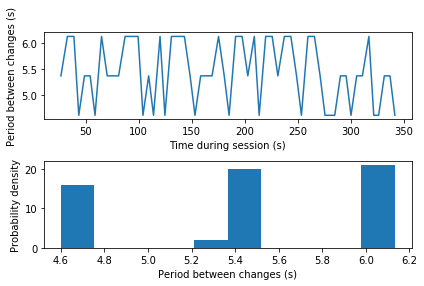

In [16]:
time_of_changes = dset.get_bit_rising_edges(6, units='sec')
plt.subplot(2,1,1)
plt.plot(time_of_changes[1:], np.diff(time_of_changes))
plt.xlabel('Time during session (s)')
plt.ylabel('Period between changes (s)')
plt.subplot(2,1,2)
plt.hist(np.diff(time_of_changes))
plt.xlabel('Period between changes (s)')
plt.ylabel('Probability density')
plt.tight_layout()


Does reward turn around time fluctuates during a session at particular time, depending on CPU avaibility?

Text(0, 0.5, 'Calculation + digital line delay (ms)')

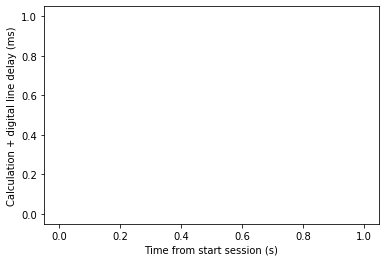

In [17]:
plt.plot(list_reward_x,list_delta_reward, 'r.')
plt.xlabel('Time from start session (s)')
plt.ylabel('Calculation + digital line delay (ms)')